<a href="https://colab.research.google.com/github/hejazn86/Sunspot_prediction/blob/master/sunspot_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [3]:
#loading the data as a list and converting it to a numpy array
import csv
import numpy


time_steps = []
sunspots = []
path = '/drive/My Drive/datasets_2418_917074_Sunspots.csv'
with open(path) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for col in reader:
    sunspots.append(float(col[2]))
    time_steps.append(int(col[0]))

print(sunspots)
import numpy as np

series = np.array(sunspots)
time = np.array(time_steps) 

print(series.shape)
print(len(series))

[96.7, 104.3, 116.7, 92.8, 141.7, 139.2, 158.0, 110.5, 126.5, 125.8, 264.3, 142.0, 122.2, 126.5, 148.7, 147.2, 150.0, 166.7, 142.3, 171.7, 152.0, 109.5, 105.5, 125.7, 116.7, 72.5, 75.5, 94.0, 101.2, 84.5, 110.5, 99.7, 39.2, 38.7, 47.5, 73.3, 58.3, 83.3, 118.3, 98.8, 99.5, 66.0, 130.7, 48.8, 45.2, 77.7, 62.7, 66.7, 73.3, 53.3, 76.2, 63.3, 60.0, 52.8, 36.7, 65.0, 46.7, 41.7, 33.3, 11.2, 0.0, 5.0, 2.8, 22.8, 34.5, 44.5, 31.3, 20.5, 13.7, 40.2, 22.0, 7.0, 17.0, 18.7, 11.3, 10.8, 0.0, 0.0, 14.3, 5.3, 29.7, 39.5, 11.3, 33.3, 20.8, 11.8, 9.0, 15.7, 20.8, 21.5, 6.0, 10.7, 19.7, 23.8, 28.3, 15.7, 23.5, 35.3, 43.7, 50.0, 63.5, 21.3, 41.7, 85.5, 66.2, 54.2, 107.8, 55.8, 62.7, 86.7, 81.7, 120.5, 77.3, 75.0, 73.3, 64.5, 104.2, 62.8, 71.7, 71.7, 80.5, 73.3, 78.0, 78.3, 81.7, 83.3, 85.0, 118.8, 128.7, 99.5, 77.2, 95.0, 112.2, 99.2, 124.5, 97.2, 120.0, 80.5, 110.0, 126.0, 102.2, 84.3, 99.5, 101.7, 116.7, 151.7, 134.5, 119.5, 178.7, 165.5, 156.8, 151.8, 167.8, 147.8, 149.5, 76.7, 73.0, 121.3, 76.2, 100

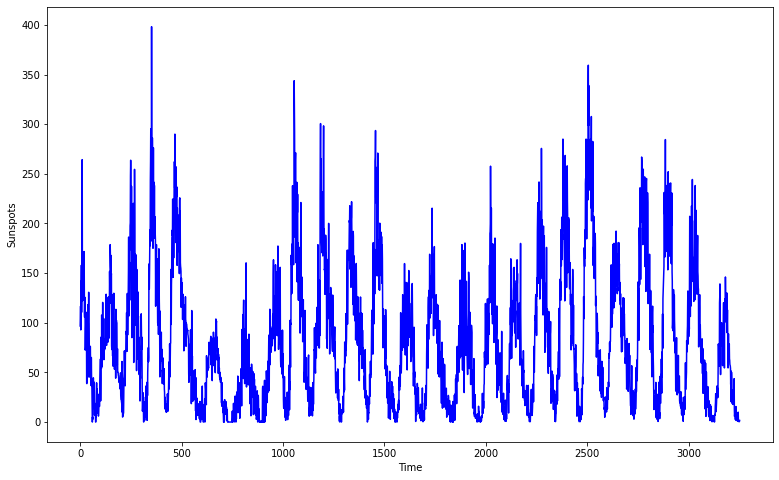

In [ ]:
#plotting the data

import matplotlib.pyplot as plt
 
plt.figure(figsize=(13, 8))
plt.plot(time, series, 'b')
plt.xlabel('Time')
plt.ylabel('Sunspots')
plt.show()

In [ ]:
# splitting the data to train and validation sets

split_time = 3500
train_time =time[:split_time]
x_train = series[:split_time]
test_time = time[split_time:]
x_test = series[split_time:]

window_size = 30
batch_size =250 
shuffle_buffer_size = 100

# prepare the dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [ ]:
window_size = 30
batch_size =250 
shuffle_buffer_size = 100

#Prepare the dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
#Using RNN 
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_data = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_data)


model = tf.keras.models.Sequential([tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                    tf.keras.layers.SimpleRNN(40, return_sequences=True),
                                    tf.keras.layers.SimpleRNN(40),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 100.0)])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), metrics = ['mae'])

history = model.fit(train_data, epochs=100, callbacks = [lr_schedule], verbose=1)

In [ ]:
#Using LSTM 
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_data = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_data)


model = tf.keras.models.Sequential([tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                    tf.keras.layers.LSTM(40, return_sequences=True),
                                    tf.keras.layers.LSTM(40),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 100.0)])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), metrics = ['mae'])

history = model.fit(train_data, epochs=100, callbacks = [lr_schedule], verbose=1)

In [ ]:
#Using Convolution and LSTM
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_data = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_data)


model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape= [None, 1]),
                                    tf.keras.layers.LSTM(32, return_sequences=True),
                                    tf.keras.layers.LSTM(32, return_sequences= True),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 200.0)])

#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9), metrics = ['mae'])

#history = model.fit(train_data, epochs=400, callbacks = [lr_schedule], verbose=1)
history = model.fit(train_data, epochs=400, verbose=1)

In [ ]:
#Building a model using bidirectional LSTM

import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)



dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='causal', strides=1, input_shape=[None, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 200)
])      

lr_setter = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-8), metrics=['mae'])

history = model.fit(dataset, epochs=100, callbacks= [lr_setter])

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
Epoch 1/100
12/12 [==============================] - 5s 436ms/step - loss: 159.6661 - mae: 160.1661 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 5s 426ms/step - loss: 159.3472 - mae: 159.8471 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 5s 433ms/step - loss: 158.9888 - mae: 159.4888 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 5s 435ms/step - loss: 158.5861 - mae: 159.0861 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 5s 431ms/step - loss: 158.1337 - mae: 158.6337 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 5s 438ms/step - loss: 157.6257 - mae: 158.1256 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 5s 428ms/step - loss: 157.0551 - mae: 157.5551 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 5s 437ms/step - loss: 156.4146 - mae: 15

(1e-08, 0.0001, 25.0, 60.0)

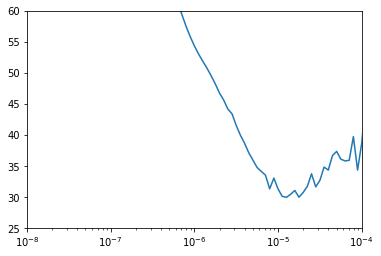

In [ ]:
import matplotlib.pyplot as plt

plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 25, 60])

In [ ]:
# building a model to predict

import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)



dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='causal', strides=1, input_shape=[None, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 200)
])      


model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=2e-5), metrics=['mae'])

history = model.fit(dataset, epochs=400)

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
Epoch 1/400
13/13 [==============================] - 5s 350ms/step - loss: 55.7640 - mae: 56.2614
Epoch 2/400
13/13 [==============================] - 5s 361ms/step - loss: 42.4415 - mae: 42.9384
Epoch 3/400
13/13 [==============================] - 5s 349ms/step - loss: 39.1669 - mae: 39.6635
Epoch 4/400
13/13 [==============================] - 5s 359ms/step - loss: 36.7338 - mae: 37.2303
Epoch 5/400
13/13 [==============================] - 5s 356ms/step - loss: 35.1051 - mae: 35.6011
Epoch 6/400
13/13 [==============================] - 5s 359ms/step - loss: 34.4097 - mae: 34.9054
Epoch 7/400
13/13 [==============================] - 5s 366ms/step - loss: 34.3218 - mae: 34.8178
Epoch 8/400
13/13 [==============================] - 5s 356ms/step - loss: 33.4065 - mae: 33.9023
Epoch 9/400
13/13 [==============================] - 5s 357ms/step - loss: 32.6102 - mae: 33.1060
Epoch 10/400
13/13 [==========

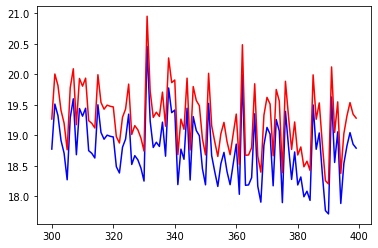

In [ ]:
import matplotlib.pyplot as plt
 
epochs = range(0, 400)
plt.plot(epochs[300:], history.history['loss'][300:], 'b')
plt.plot(epochs[300:], history.history['mae'][300:], 'r')
plt.show()

In [ ]:
# forcasting (testing the model)

def Forcast_func(model, series, window_size):
  #series = tf.expand_dims(series, axis=-1)
  data_set = tf.data.Dataset.from_tensor_slices(series)
  data_set= dataset.window(window_size + 1, shift=1, drop_remainder=True)
  data_set = dataset.flat_map(lambda window: window.batch(window_size + 1))
  data_set = dataset.batch(batch_size).prefetch(1)
  forcast = model.predict(data_set)
  return forcast



estimated = Forcast_func(model, series[split_time - window_size:, np.newaxis], window_size)
results = estimated[split_time - window_size:-1, -1, 0]


plt.figure(figsize=(11, 8))
plt.plot(test_time, x_test, 'b*', label='real_data')
plt.plot(test_time, result, 'ro', label='predicted')


TypeError: ignored